<a href="https://colab.research.google.com/github/min207/ESAA/blob/main/ESAA1125.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **04. 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측**

------------------------------------
**LinearRegression 클래스 - Ordinary Least Squares**
: 예측값과 실제값의 RSS를 최소화해 OLS 추정 방식으로 구현한 클래스
: fit() 메서드로 X, y 배열을 입력 받으면 회귀 계수인 W를 coef_ 속성에 저장

class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

- 입력 파라미터
  + fit_intercept
  + normalize
- 속성
  + coef_
  + intercept_

- OLS 기반의 회귀 계수 계산은 입력 피처의 독립성에 많은 영향을 받음
- 상관관계가 높을 경우, 분산이 커지면서 오류에 민감 > 다중 공선성 문제

-------------------------------------
**회귀 평가 지표**
: 실제 값과 회귀 예측값의 차이 값을 기반으로 한 지표 중심 > 그냥 합할 경우 오류가 상쇄 되기 때문에 다른 방법 사용
- 평가 지표
  + MAE: metrics.mean_absolute_error / neg_mean_absolute_error
  + MSE: metrics.mean_squared_error / neg_mean_squared_error
  + RMSE
  + R^2: metrics.r2_score / r2
  + 그 외 MSLE, RMSLE 사용

- Scoring 함수에 회귀 평가 지표를 사용할 때, neg는 음수를 의미하는 접두어이므로 모델에 안 좋은 영향을 끼칠 수 있음 > 음수 값을 반환하지 않도록 주의 필요

--------------------------------------
**LinearRegression을 이용해 보스턴 주택 가격 회귀 구현**



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

# boston 데이타셋 로드
boston = load_boston()

# boston 데이타셋 DataFrame 변환 
bostonDF = pd.DataFrame(boston.data , columns = boston.feature_names)

# boston dataset의 target array는 주택 가격임. 이를 PRICE 컬럼으로 DataFrame에 추가함. 
bostonDF['PRICE'] = boston.target
print('Boston 데이타셋 크기 :',bostonDF.shape)
bostonDF.head()

Boston 데이타셋 크기 : (506, 14)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


> Null 값 없고 전부 float형임
- 칼럼 별 회귀 결과에 미치는 영향 시각화

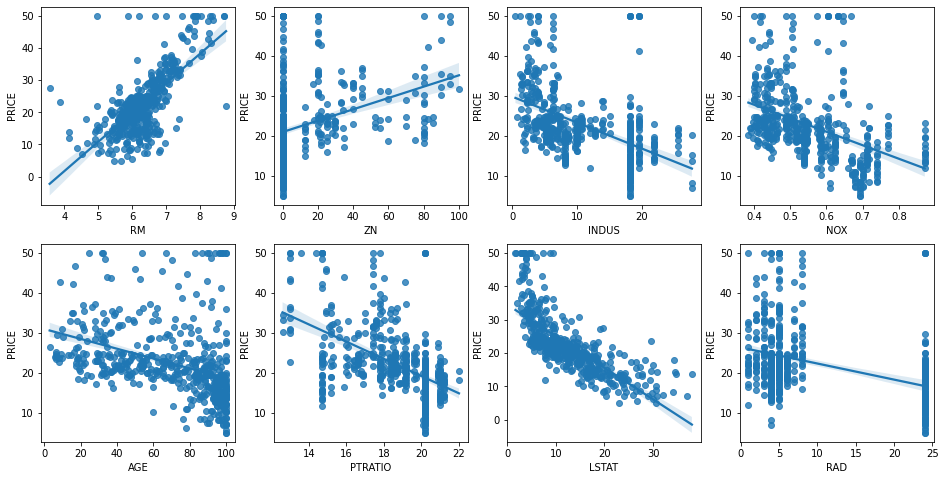

In [2]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16,8) , ncols=4 , nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i , feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature , y='PRICE',data=bostonDF , ax=axs[row][col])

> 다른 칼럼에 비해 RM, LSTAT의 PRICE 영향도가 가장 두드러짐: RM은 양 방향의 선형성, LSTAT의 PRICE는 음 방향의 선형성
- LInearRegression 클래스를 이용해 회귀 모델 생성

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error , r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)

X_train , X_test , y_train , y_test = train_test_split(X_data , y_target ,test_size=0.3, random_state=156)

# Linear Regression OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train ,y_train )
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3F}'.format(mse , rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297 , RMSE : 4.159
Variance score : 0.757


> - 절편과 회귀 계수 값 확인

In [4]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.99559517216477
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


> - coef_속성은 회귀 계수 값만 가지므로 피처별 회귀 계수 값으로 다시 매핑, 높은 순으로 출력: Series의 sort_values()함수 이용

In [5]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. index가 컬럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns )
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

> RM은 양의 값으로 회귀 계수가 가장 크고, NOX 피처의 회귀 계수 - 값이 지나치게 큼 > 최적화 진행
- 5개 폴드 세트에서 cross_val_score()을 이용해 교차 검증으로 MSE, RMSE 측정 > 음수 값으로 반환되는 것을 방지 하기 위해서 반환 값에 다시 -1을 곱하여 값 보정

In [6]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1,inplace=False)
lr = LinearRegression()

# cross_val_score( )로 5 Fold 셋으로 MSE 를 구한 뒤 이를 기반으로 다시  RMSE 구함
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수 
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829 


> score(scoring="neg_mean_squared_error")로 반환된 값 모두 음수임을 확인 가능
> / 평균 RMSE는 약 5.829